## Import & Transform COCO Images

In [4]:
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
#from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import requests, zipfile

# === Download COCO Images Subset ===
coco_dir = '/home/mhite2/MSA 8600/coco'
img_dir = os.path.join(coco_dir, 'train2017')
if not os.path.exists(img_dir):
    os.makedirs(coco_dir, exist_ok=True)
    r = requests.get('http://images.cocodataset.org/zips/train2017.zip')
    with open('/home/mhite2/MSA 8600/coco/train2017.zip', 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile('/home/mhite2/MSA 8600/coco/train2017.zip', 'r') as zip_ref:
        zip_ref.extractall(coco_dir)

In [5]:
image_paths = sorted(glob(os.path.join(img_dir, '*.jpg')))[:100000]  # Take only 100000 images

In [6]:
transform = transforms.Compose([
    transforms.Resize(64), # 64 original
    transforms.CenterCrop(64), # 64 original
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class CocoSubsetDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img)

dataset = CocoSubsetDataset(image_paths, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2) # batchsize=64 original

## Define Generator/Discriminator

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0),    # 1x1 → 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),       # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),       # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),        # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),          # 32x32 → 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 64, 4, 2, 1)     # 64 → 32
        self.layer2 = nn.Conv2d(64, 128, 4, 2, 1)   # 32 → 16
        self.layer3 = nn.Conv2d(128, 256, 4, 2, 1)  # 16 → 8
        self.layer4 = nn.Conv2d(256, 512, 4, 2, 1)  # 8 → 4
        self.final = nn.Conv2d(512, 1, 4, 1, 0)     # 4 → 1
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn512 = nn.BatchNorm2d(512)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(f"Input: {x.shape}")
        x = self.leaky_relu(self.layer1(x))       # → (B, 64, 32, 32)
        x = self.leaky_relu(self.bn128(self.layer2(x)))  # → (B, 128, 16, 16)
        x = self.leaky_relu(self.bn256(self.layer3(x)))  # → (B, 256, 8, 8)
        x = self.leaky_relu(self.bn512(self.layer4(x)))  # → (B, 512, 4, 4)
        x = self.sigmoid(self.final(x))           # → (B, 1, 1, 1)
        # print(f"Final output shape: {x.shape}")
        return x.view(-1)


G = Generator().to(device)
D = Discriminator().to(device)

## Training & Image Generation

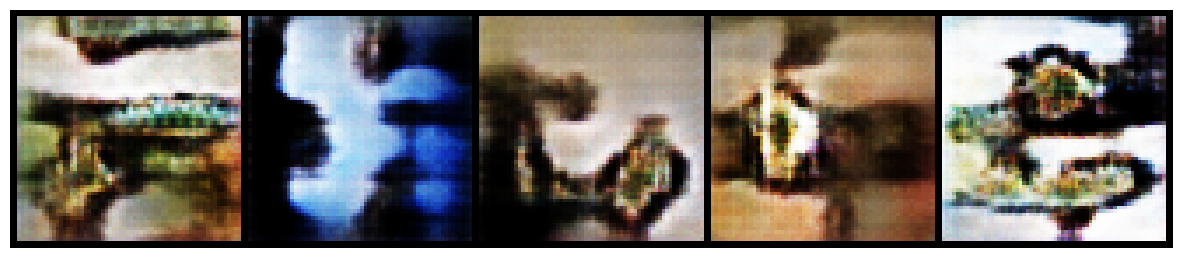

Epoch 1/20 | Loss_D: 0.3313 | Loss_G: 3.6612


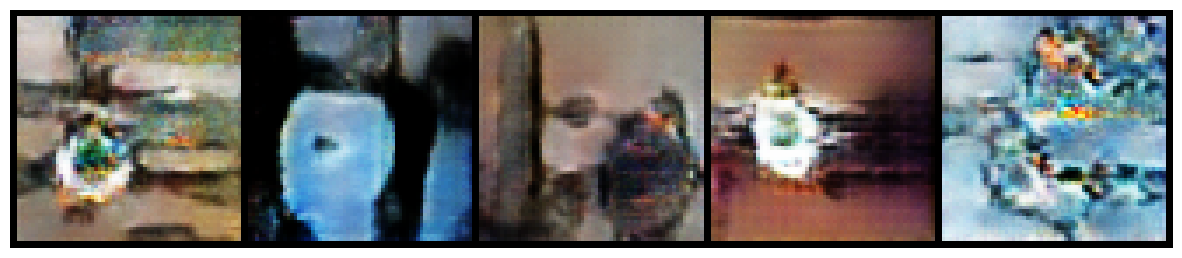

Epoch 2/20 | Loss_D: 0.2776 | Loss_G: 4.8316


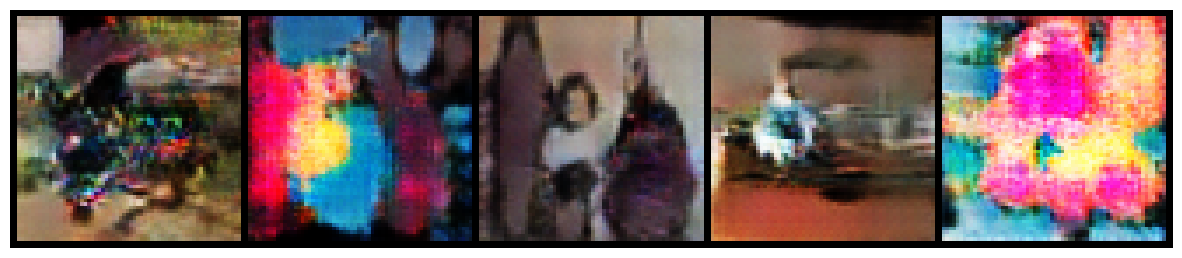

Epoch 3/20 | Loss_D: 0.2581 | Loss_G: 4.3724


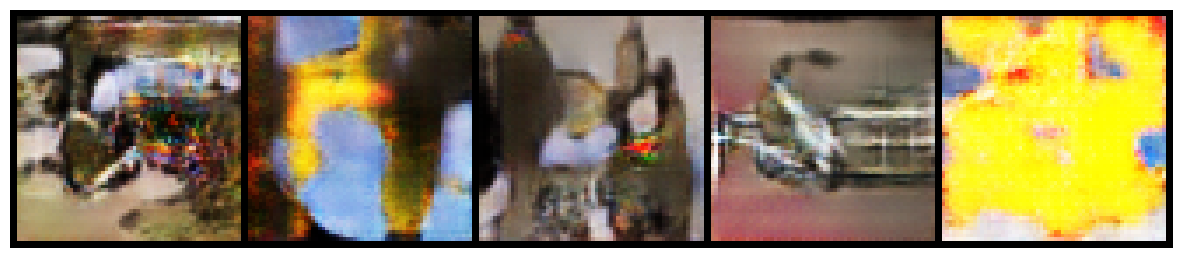

Epoch 4/20 | Loss_D: 0.1895 | Loss_G: 3.7585


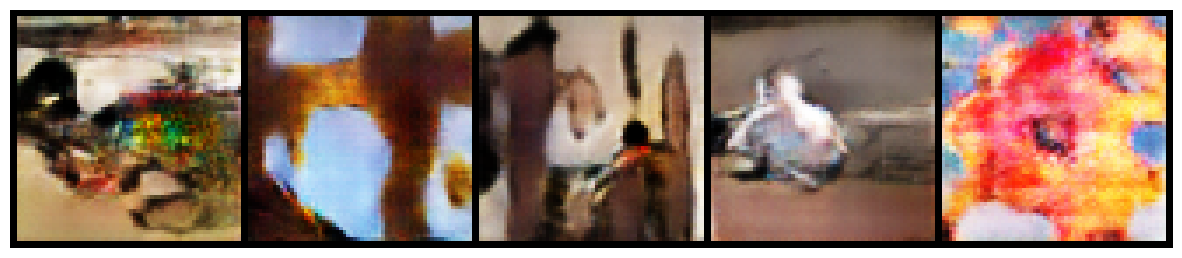

Epoch 5/20 | Loss_D: 1.8669 | Loss_G: 1.5644


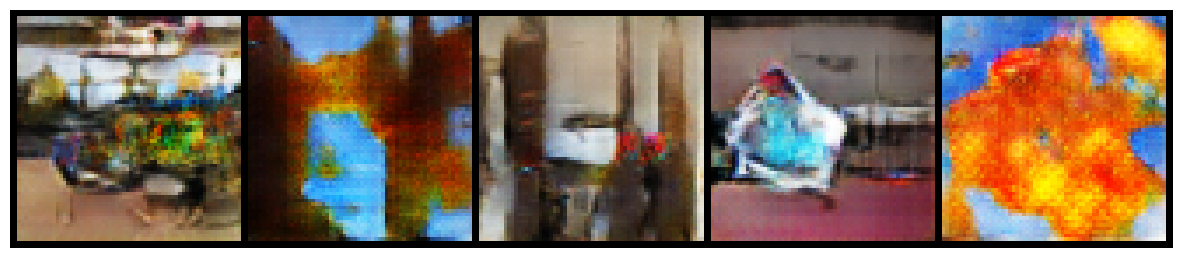

Epoch 6/20 | Loss_D: 0.4003 | Loss_G: 4.0382


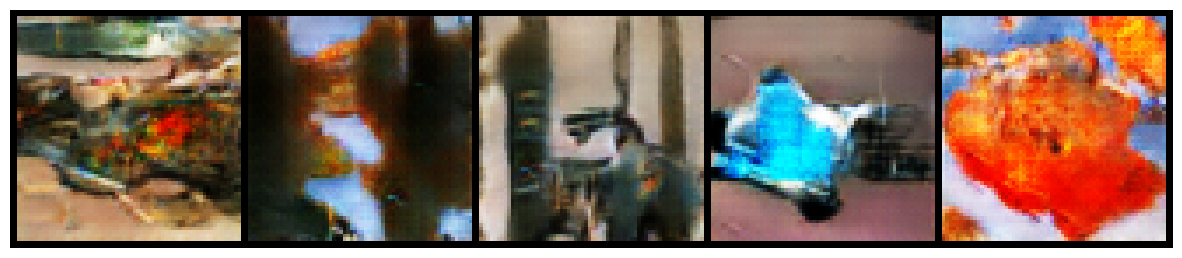

Epoch 7/20 | Loss_D: 0.6467 | Loss_G: 1.1964


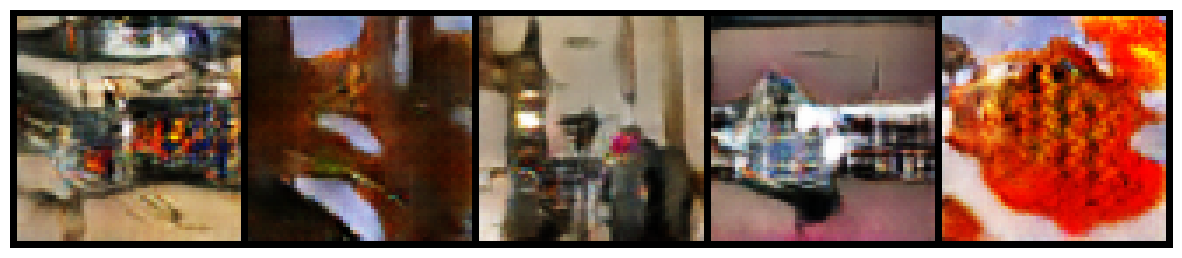

Epoch 8/20 | Loss_D: 0.2348 | Loss_G: 3.0712


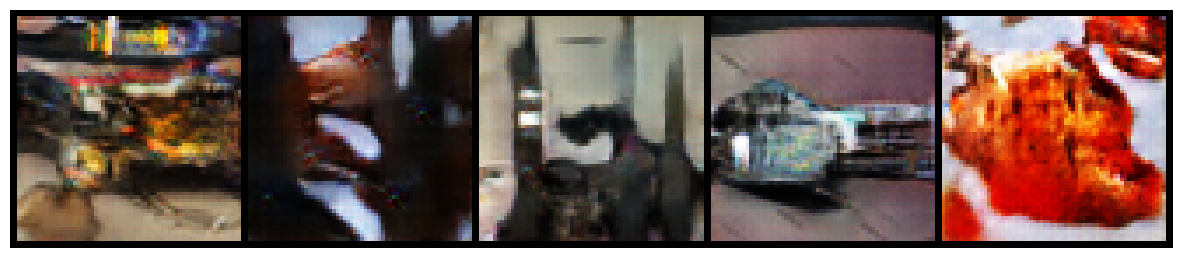

Epoch 9/20 | Loss_D: 33.1746 | Loss_G: 5.5340


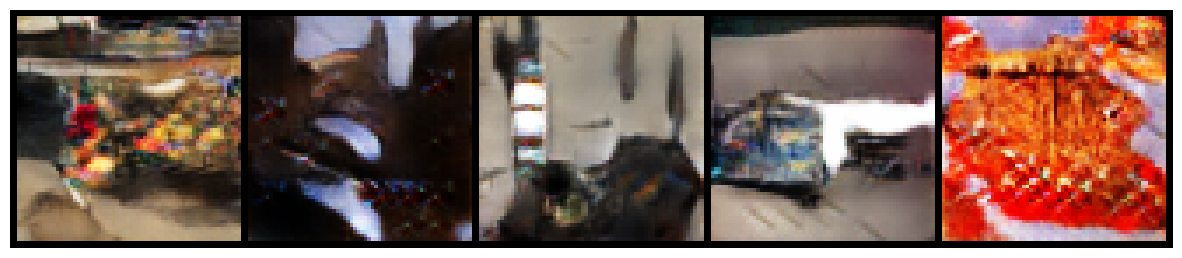

Epoch 10/20 | Loss_D: 0.3611 | Loss_G: 9.1488


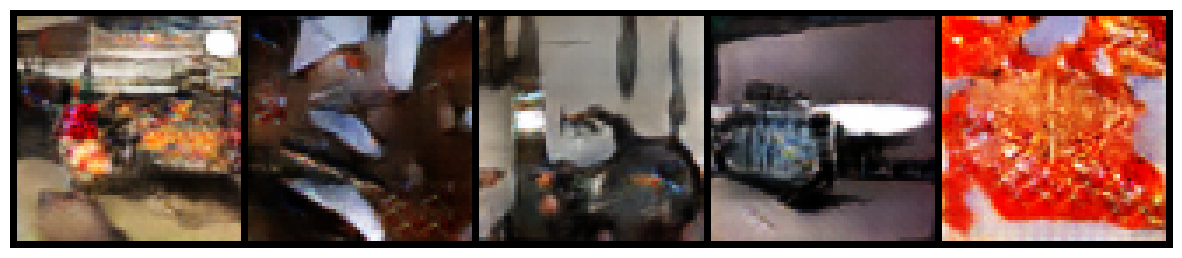

Epoch 11/20 | Loss_D: 0.0844 | Loss_G: 3.4047


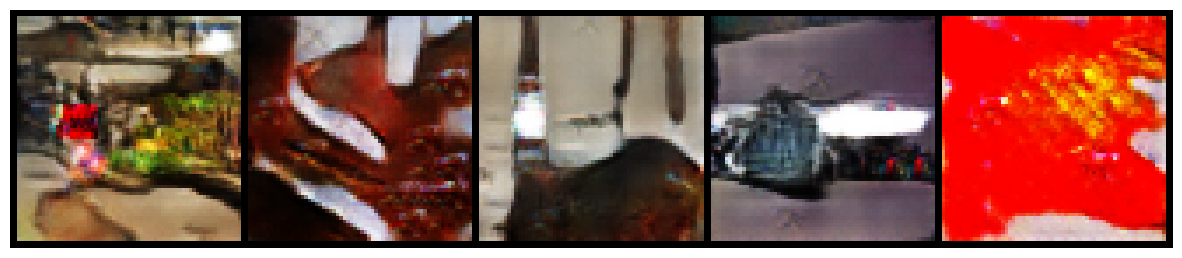

Epoch 12/20 | Loss_D: 0.3739 | Loss_G: 1.4036


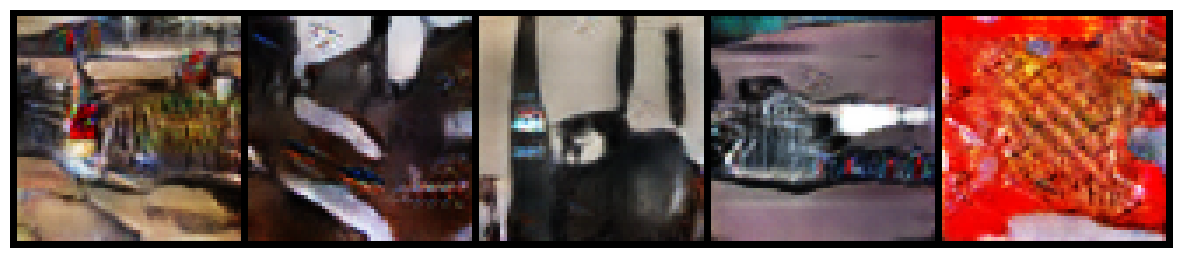

Epoch 13/20 | Loss_D: 0.2989 | Loss_G: 2.4984


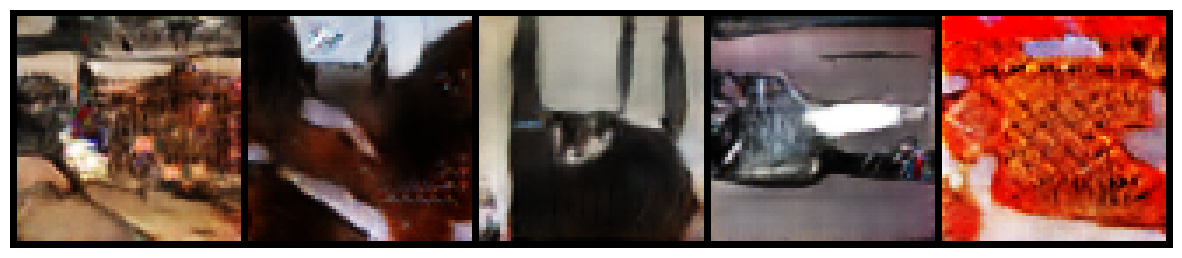

Epoch 14/20 | Loss_D: 0.1364 | Loss_G: 3.3235


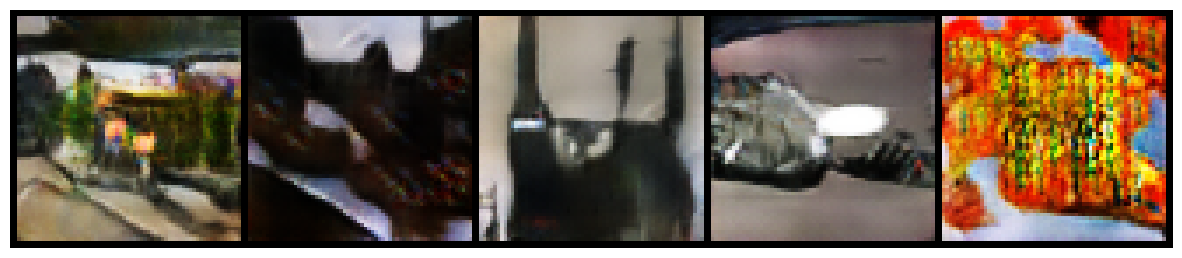

Epoch 15/20 | Loss_D: 0.0671 | Loss_G: 4.9483


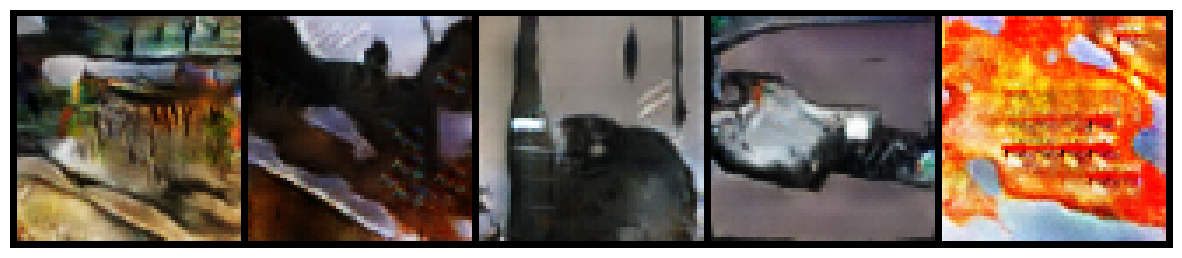

Epoch 16/20 | Loss_D: 0.1013 | Loss_G: 4.0729


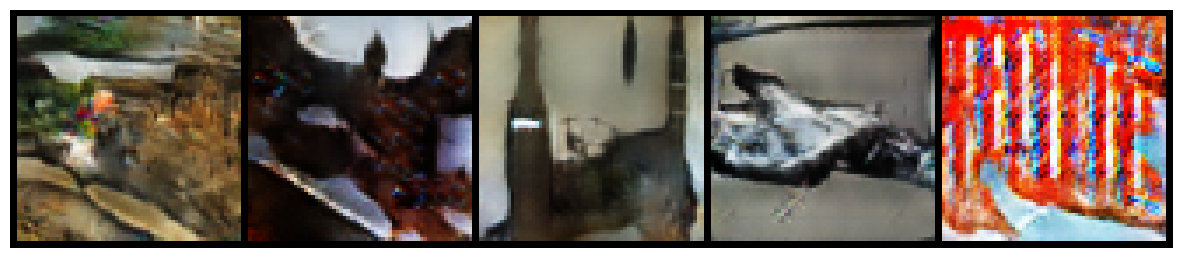

Epoch 17/20 | Loss_D: 1.2752 | Loss_G: 13.5624


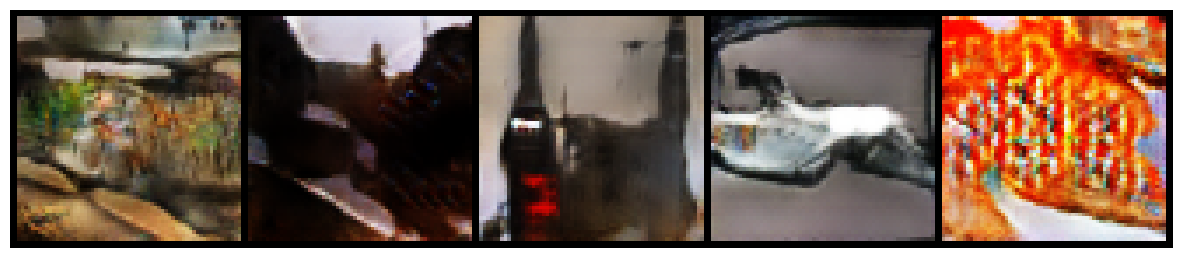

Epoch 18/20 | Loss_D: 0.0721 | Loss_G: 5.0984


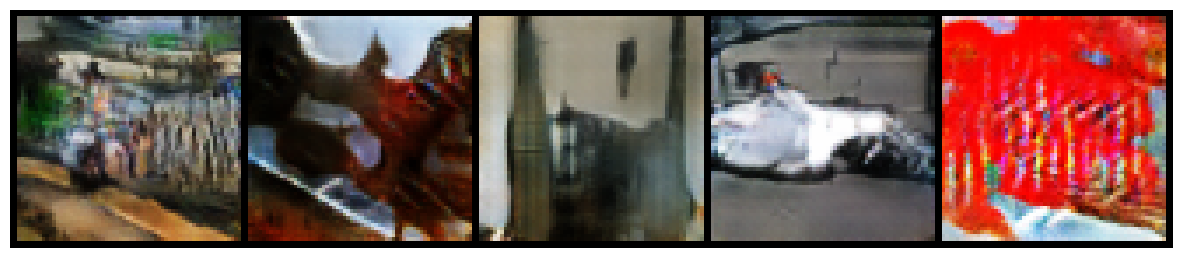

Epoch 19/20 | Loss_D: 0.0920 | Loss_G: 5.5203


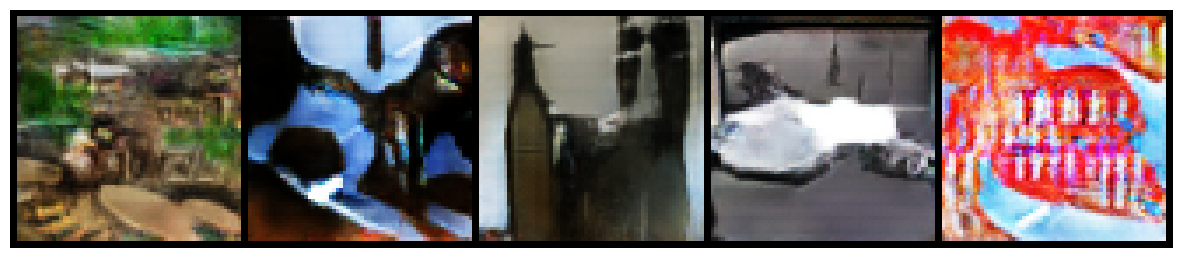

Epoch 20/20 | Loss_D: 0.0599 | Loss_G: 5.2914


In [9]:
import torchvision.utils as vutils
z_dim = 100
lr = 0.0002
num_epochs = 20

criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(5, z_dim, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        real = data.to(device)
        b_size = real.size(0)
        
        # Train Discriminator
        D.zero_grad()
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = D(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = G(noise)
        label.fill_(0.)
        output = D(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        G.zero_grad()
        label.fill_(1.)
        output = D(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    G.eval()
    with torch.no_grad():
        fake_images = G(fixed_noise).detach().cpu()
    
    # Show images
    grid = vutils.make_grid(fake_images, normalize=True, nrow=5)
    plt.figure(figsize=(15,5))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show();

    print(f"Epoch {epoch+1}/{num_epochs} | Loss_D: {errD_real + errD_fake:.4f} | Loss_G: {errG:.4f}")